### Setup

In [5]:
import tensorflow as tf
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

### Read Cifar-10 Dataset

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = np.concatenate((x_train, x_test), axis = 0)/255

170500096/170498071 [==============================] - 32s 0us/step


### Plot some of the image for checking

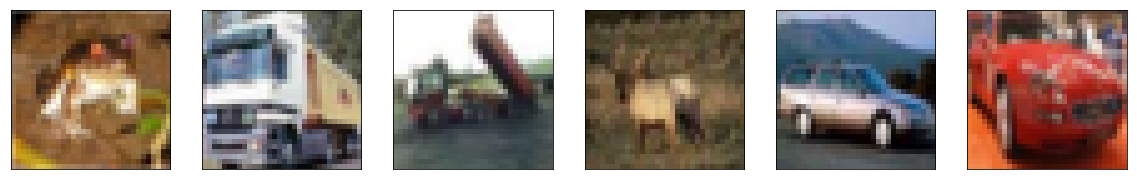

In [7]:
fig, axes = plt.subplots(figsize=(20, 4), nrows=1, ncols=6, sharey=True, sharex=False)
for i in range(6):
    axes[i].xaxis.set_visible(False)
    axes[i].yaxis.set_visible(False)
    im = axes[i].imshow(x_train[i])

### Declare Global Variables

In [8]:
training_set = x_train
samples = []
losses = []
gen_dims = 100
weights = []

### Some Helper Functions

In [9]:
def sample_noise(batch_size, dim):
    return np.random.uniform(-1, 1, (batch_size, dim))

In [10]:
def next_batch(data, batch_size = 128):
    number_of_partitions = data.shape[0] // batch_size
    np.random.shuffle(training_set)
    
    for batch in np.array_split(training_set[:number_of_partitions * batch_size], number_of_partitions):
        yield batch * 2 - 1  # scale to -1 to 1

In [11]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5, 5)):
        fig, axes = plt.subplots(figsize = figsize, nrows = nrows, ncols= ncols, sharey = True, sharex = True)

        for ax, img in zip(axes.flatten(), samples[epoch]):
            ax.axis('off')
            img = ((img - img.min()) * 255 / (img.max() - img.min())).astype(np.uint8)
            ax.set_adjustable('box-forced')
            im = ax.imshow(img, aspect = 'equal')
        plt.subplots_adjust(wspace = 0, hspace = 0)
        return fig, axes

### Setup Discriminator and Generator

In [12]:
def discriminator(x, reuse = False):
    with tf.variable_scope("discriminator", reuse = reuse):
        x = tf.reshape(x, [-1, 32, 32, 3])
        layer_1 = tf.layers.conv2d(x, filters = 32, kernel_size = 5, strides = (2, 2), activation = tf.nn.leaky_relu, padding = "same", kernel_initializer = tf.contrib.layers.xavier_initializer())
        
        layer_2 = tf.layers.conv2d(layer_1, filters = 64, kernel_size = 5, strides = (2, 2), padding = "same", kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer_2_1 = tf.layers.batch_normalization(layer_2, training = True)
        layer_2_2 = tf.nn.leaky_relu(layer_2_1)
        
        layer_3 = tf.layers.conv2d(layer_2_2, filters = 128, kernel_size = 5, strides = (2, 2), padding = "same", kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer_3_1 = tf.layers.batch_normalization(layer_3, training = True)
        layer_3_2 = tf.nn.leaky_relu(layer_3_1)
        
        layer_4 = tf.layers.conv2d(layer_3_2, filters = 256, kernel_size = 5, strides = (2, 2), padding = "same", kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer_4_1 = tf.layers.batch_normalization(layer_4, training = True)
        layer_4_2 = tf.nn.leaky_relu(layer_4_1)
        
        layer_4_flatten = tf.layers.flatten(layer_4_2)
        layer_5 = tf.layers.dense(layer_4_flatten, 1, kernel_initializer = tf.contrib.layers.xavier_initializer())
        logits = layer_5
        out = tf.sigmoid(layer_5)
        return out, logits

In [13]:
def generator(z, reuse = False):
    with tf.variable_scope("generator", reuse = reuse):
        layer_1 = tf.layers.dense(z, 1024)
        layer_1_1 = tf.layers.batch_normalization(layer_1, training = True)
        layer_1_2 = tf.nn.leaky_relu(layer_1_1)
        layer_1_3 = tf.reshape(layer_1_2, [-1, 2, 2, 256])
        
        layer_2 = tf.layers.conv2d_transpose(layer_1_3, filters = 128, kernel_size = 5, strides = (2, 2), padding = "same", kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer_2_1 = tf.layers.batch_normalization(layer_2, training = True)
        layer_2_2 = tf.nn.leaky_relu(layer_2_1)
        
        layer_3 = tf.layers.conv2d_transpose(layer_2_2, filters = 64, kernel_size = 5, strides = (2, 2), padding = "same", kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer_3_1 = tf.layers.batch_normalization(layer_3, training = True)
        layer_3_2 = tf.nn.leaky_relu(layer_3_1)
        
        layer_4 = tf.layers.conv2d_transpose(layer_3_2, filters = 32, kernel_size = 5, strides = (2, 2), padding = "same", kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer_4_1 = tf.layers.batch_normalization(layer_4, training = True)
        layer_4_2 = tf.nn.leaky_relu(layer_4_1)
        
        layer_5 = tf.layers.conv2d_transpose(layer_4_2, filters = 3, kernel_size = 5, strides = (2, 2), activation = tf.tanh, padding = "same", kernel_initializer = tf.contrib.layers.xavier_initializer())
        img = layer_5
        return img

### Setup Loss Fuctions and Optimizers

In [14]:
def gan_loss(logits_real, logits_fake):
    G_loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(logits_fake), logits = logits_fake))
    D_loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(logits_real), logits = logits_real)) + tf.reduce_mean(tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.zeros_like(logits_fake), logits = logits_fake))
    return D_loss, G_loss

In [15]:
def loss_and_optimize(lr = 5e-4, beta1 = 0.5, beta2 = 0.999):
    tf.reset_default_graph()
    
    gen_input = tf.placeholder(shape=(None, gen_dims), dtype=tf.float32)
    real_input = tf.placeholder(shape=(None, 32, 32, 3), dtype=tf.float32)
    
    G_sample = generator(gen_input, reuse = False)
    
    out_real, logits_real = discriminator(real_input, reuse = False)
    out_fake, logits_fake = discriminator(G_sample, reuse = True)
    
    D_loss, G_loss = gan_loss(logits_real, logits_fake)
    
    generator_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
    discriminator_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        generator_optimizer = tf.train.AdamOptimizer(learning_rate = lr, beta1 = beta1, beta2 = beta2).minimize(G_loss, var_list = generator_variables)
        discriminator_optimizer = tf.train.AdamOptimizer(learning_rate = lr, beta1 = beta1, beta2 = beta2).minimize(D_loss, var_list = discriminator_variables)
        
    return discriminator_optimizer, generator_optimizer, D_loss, G_loss, gen_input, real_input

### Define Training Process

In [16]:
def train(batch_size=128, epochs=100):
    discriminator_optimizer, generator_optimizer, D_loss, G_loss, G_sample, real_input = loss_and_optimize()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        for epoch in tqdm(range(epochs)):
            for step, batch in enumerate(next_batch(training_set, batch_size)):
                noise = sample_noise(batch_size, gen_dims)
                _ = sess.run(generator_optimizer, feed_dict = {G_sample: noise, real_input: batch})
                _ = sess.run(discriminator_optimizer, feed_dict = {G_sample: noise, real_input: batch})
                gen_loss, dis_loss = sess.run([G_loss, D_loss], feed_dict = {G_sample: noise, real_input: batch})
                losses.append((gen_loss, dis_loss))
                #print(gen_loss, " ", dis_loss)

            if epoch % 2 == 0:
                sampled_noise = sample_noise(72, gen_dims)
                gen_samples = sess.run(generator(G_sample, reuse = True), feed_dict = {G_sample: sampled_noise})
                samples.append(gen_samples)
                _ = view_samples(-1, samples, 6, 12, figsize = (10, 5))
                plt.show()

### Start Training!!

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


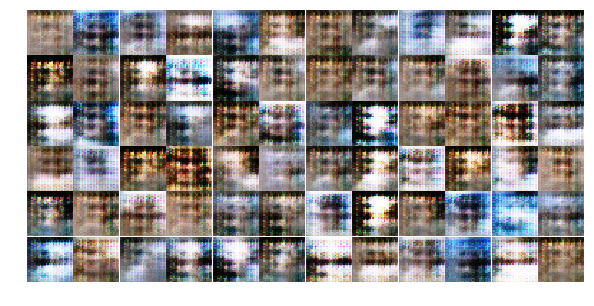

  7%|▋         | 2/30 [02:26<34:50, 74.66s/it]

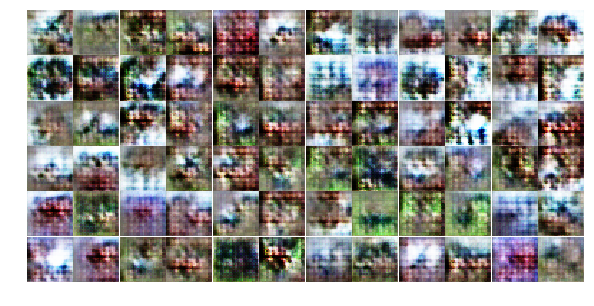

 13%|█▎        | 4/30 [04:49<31:36, 72.96s/it]

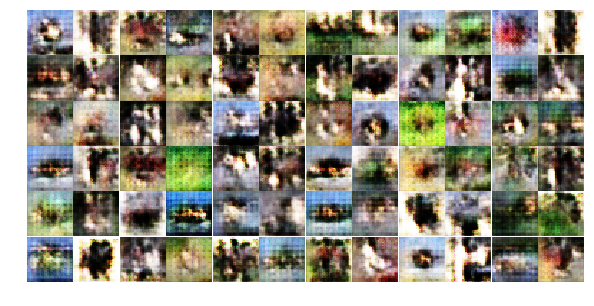

 20%|██        | 6/30 [07:13<28:50, 72.12s/it]

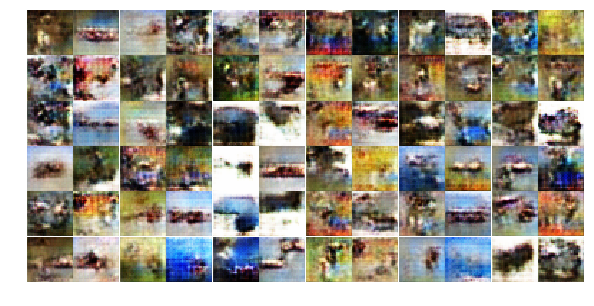

 27%|██▋       | 8/30 [09:36<26:17, 71.70s/it]

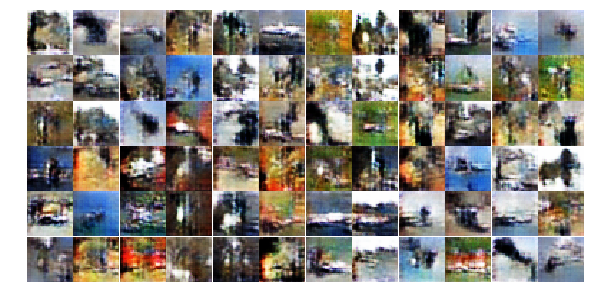

 33%|███▎      | 10/30 [11:59<23:48, 71.43s/it]

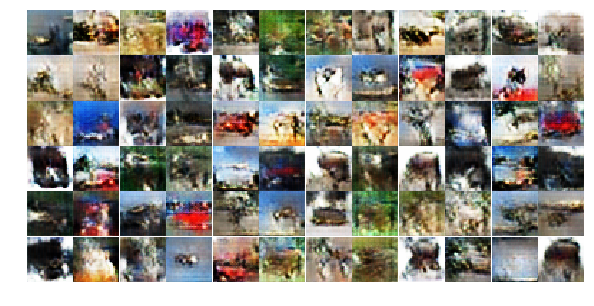

 40%|████      | 12/30 [14:22<21:25, 71.40s/it]

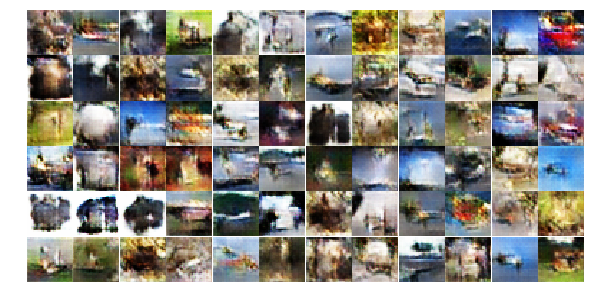

 47%|████▋     | 14/30 [16:45<19:00, 71.31s/it]

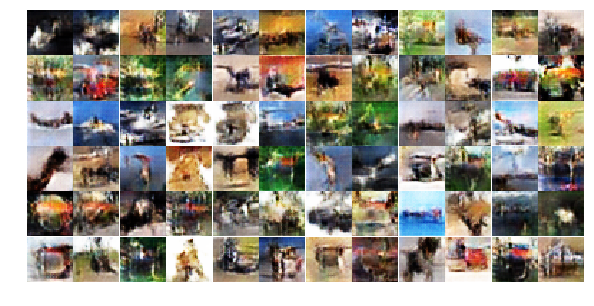

 53%|█████▎    | 16/30 [19:08<16:38, 71.29s/it]

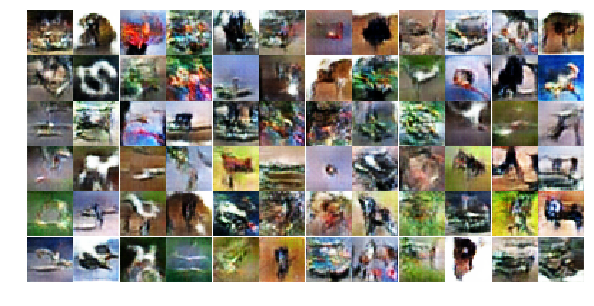

 60%|██████    | 18/30 [21:32<14:15, 71.31s/it]

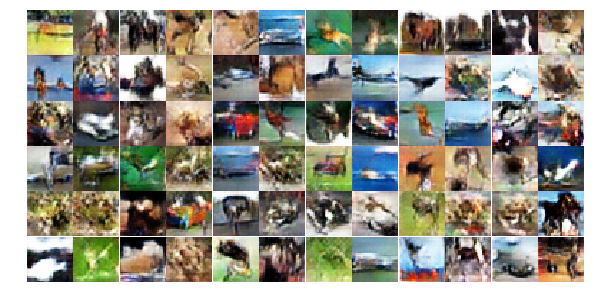

 67%|██████▋   | 20/30 [23:54<11:52, 71.25s/it]

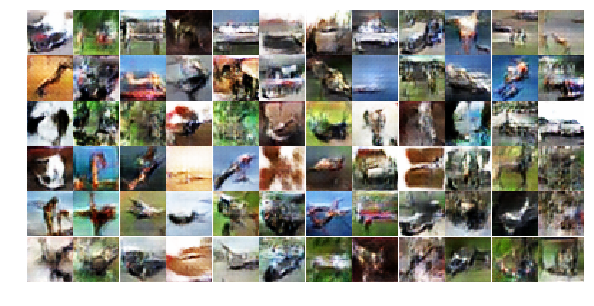

 73%|███████▎  | 22/30 [26:18<09:30, 71.31s/it]

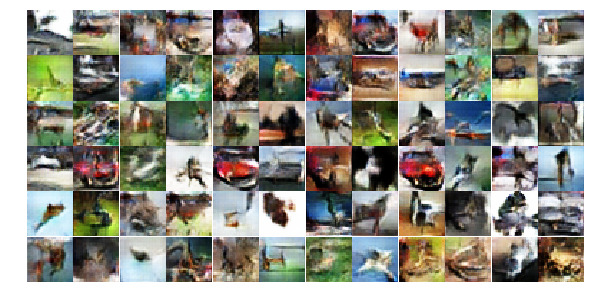

 80%|████████  | 24/30 [28:41<07:07, 71.32s/it]

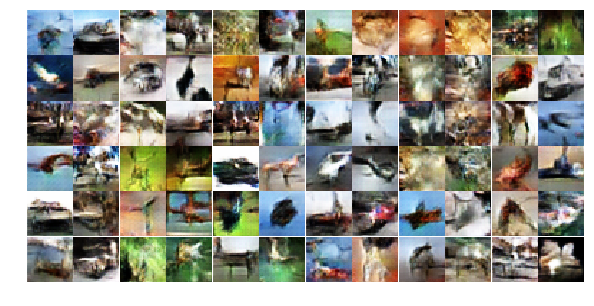

 87%|████████▋ | 26/30 [31:04<04:45, 71.34s/it]

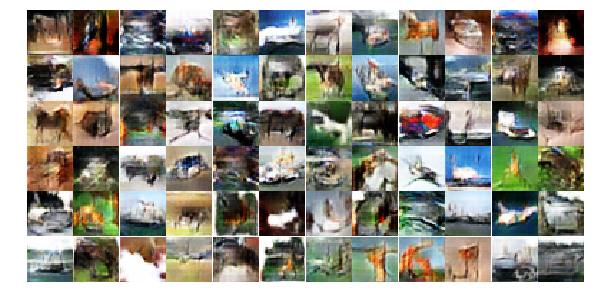

 93%|█████████▎| 28/30 [33:27<02:22, 71.27s/it]

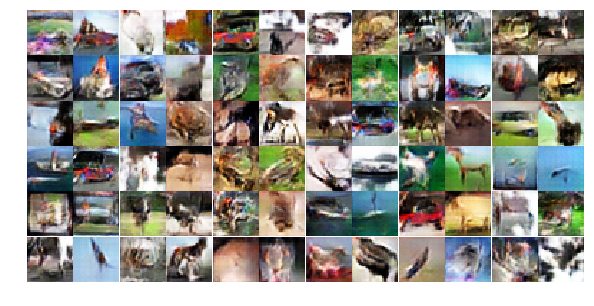

100%|██████████| 30/30 [35:51<00:00, 71.28s/it]


In [17]:
train(batch_size=128, epochs=30)